In [1]:
import os
os.chdir('../') #if we are in notebooks folder

In [2]:
import flax
from flax import linen as nn
from flax.core import unfreeze

import jax
import jax.numpy as jnp
import optax

import matplotlib.pyplot as plt
import seaborn as sns

from datasets import cos_normal_noise


from models import mc_dropout
from utils import fit

## Load Dataset

In [3]:
dataset, targets = cos_normal_noise.load()
X, x_test1, x_test2 = dataset
y, y_test1, y_test2 = targets

# MC Dropout

In [4]:
# load the model
model = mc_dropout.load(features=[1, 32, 64, 1])

In [5]:
# initialize model
params = model.init(jax.random.PRNGKey(0), X, deterministic = True)

In [6]:
model.tabulate(jax.random.PRNGKey(1), X, deterministic=True)

                            load Summary                            
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path            ┃ outputs               ┃ params                 ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Inputs          │ - float32[100,1]      │                        │
│                 │ - deterministic: True │                        │
├─────────────────┼───────────────────────┼────────────────────────┤
│ Dense_0         │ float32[100,1]        │ bias: float32[1]       │
│                 │                       │ kernel: float32[1,1]   │
│                 │                       │                        │
│                 │                       │ 2 (8 B)                │
├─────────────────┼───────────────────────┼────────────────────────┤
│ Dense_1         │ float32[100,32]       │ bias: float32[32]      │
│                 │                       │ kernel: float32[1,32]  │
│                 │                       │                        │
│                 │                       │ 64 (256 B)             │
├─────────────────┼───────────────────────┼────────────────────────┤
│ Dense_1_dropout │ float32[100,32]       │                        │
├─────────────────┼───────────────────────┼────────────────────────┤
│ Dense_2         │ float32[100,64]       │ bias: float32[64]      │
│                 │                       │ kernel: float32[32,64] │
│                 │                       │                        │
│                 │                       │ 2,112 (8.4 KB)         │
├─────────────────┼───────────────────────┼────────────────────────┤
│ Dense_2_dropout │ float32[100,64]       │                        │
├─────────────────┼───────────────────────┼────────────────────────┤
│ Dense_3         │ float32[100,1]        │ bias: float32[1]       │
│                 │                       │ kernel: float32[64,1]  │
│                 │                       │                        │
│                 │                       │ 65 (260 B)             │
├─────────────────┼───────────────────────┼────────────────────────┤
│ load            │ float32[100,1]        │                        │
├─────────────────┼───────────────────────┼────────────────────────┤
│                 │                 Total │ 2,243 (9.0 KB)         │
└─────────────────┴───────────────────────┴────────────────────────┘
                                                                    
                  Total Parameters: 2,243 (9.0 KB)                  

'\n\n'

In [7]:
auxs = {
    "X" : X,
    "y" : y,
    "deterministic": False,
    "rate" : 0.03
}
params, losses =  fit(model, params, auxs, learning_rate=0.01, epochs=100, verbose=True)

Loss step 0:  0.06402343
Loss step 10:  0.032799445
Loss step 20:  0.026476236
Loss step 30:  0.018294936
Loss step 40:  0.014485865
Loss step 50:  0.012761113
Loss step 60:  0.010920648
Loss step 70:  0.009500865
Loss step 80:  0.007964087
Loss step 90:  0.0065363776


Text(0, 0.5, 'y')

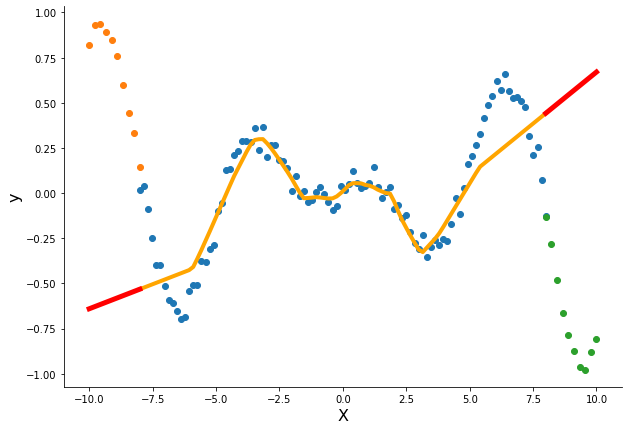

In [8]:
plt.figure(figsize=(10,7))
plt.scatter(X,y)
plt.scatter(x_test1,y_test1)
plt.scatter(x_test2,y_test2)
plt.plot(X, model.apply(params, X, deterministic=True), "orange", linewidth=4)
plt.plot(x_test1, model.apply(params,x_test1, deterministic=True),"red", linewidth = 5)
plt.plot(x_test2, model.apply(params,x_test2, deterministic=True), "red", linewidth = 5)
sns.despine()
plt.xlabel("X",fontsize=16)
plt.ylabel("y",fontsize=16)

In [9]:
x = jnp.linspace(-10, 10, 200).reshape(-1,1)
n_stacks = 100
y_stacks = []
for i in range(n_stacks):
    y_stacks.append(model.apply(params, x, deterministic=False, rate = 0.1, rngs={"dropout": jax.random.PRNGKey(i)}))

In [10]:
y_stacks = jnp.array(y_stacks)

(-10.0, 10.0)

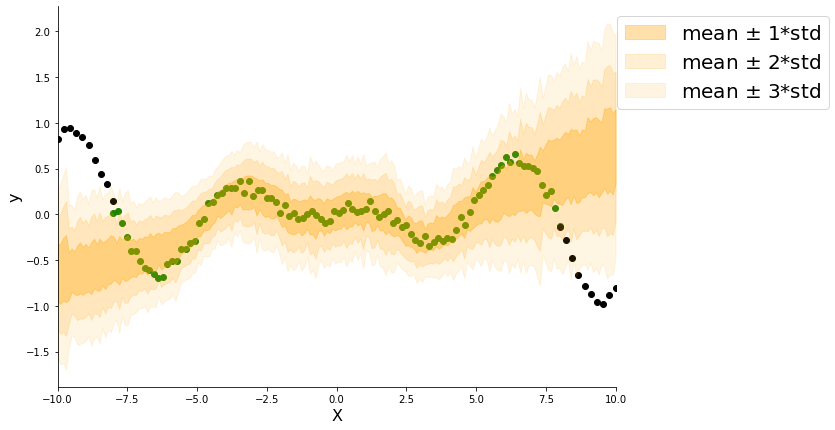

In [14]:
plt.figure(figsize=(10,7))
plt.scatter(X, y, c="g")
plt.scatter(x_test1,y_test1, c="k")
plt.scatter(x_test2,y_test2, c="k")
mean = (y_stacks.mean(axis=0)).squeeze()
std = (y_stacks.std(axis=0)).squeeze()
for i in range(1,4):
    plt.fill_between(x.squeeze(), mean - i*std, mean + i*std, color="orange", alpha = 1/(i*3), label = f"mean $\pm$ {i}*std")
plt.legend(bbox_to_anchor=(1.4,1), fontsize=20)
sns.despine()
plt.xlabel("X",fontsize=16)
plt.ylabel("y",fontsize=16)
plt.xlim(-10,10)
# plt.savefig("mc_dropout_.pdf",bbox_inches="tight")